# Notebook **Three** - How do candidate BCG spectroscopic redshifts compare to the original cluster redshifts?

This notebook contains everything necessary for you to work on the third step of this project - 
 
**Galaxy clusters** are single, gravitationally bound, objects made up of a **lot** of dark matter, quite a lot of hot gas (which is what emits X-rays), and the galaxies themselves (there are other components, but they don't matter right now).

**A BCG** is the most massive, brightest, galaxy in a cluster (though there can be multiple BCGs, or no obvious BCG at all).


**What questions are we asking at this stage of the project?**

1. How do the original redshifts for the cluster sample we're investigating compare to the spectroscopic redshifts of the BCG candidates?
2. In cases where BCG candidates have multiple identified spectra, do the different spectroscopic redshift measurements agree? 

## Import statements and reading history/sample

In [1]:
from ident_run_setup import cosmo, side_length, HISTORY_FILE_PATH, load_history, proj_name, update_history

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
import json
import os

%matplotlib inline

The framework I've designed for this process (i.e. these notebooks) is trying to keep a useful history of the process - it has recorded the images that we were able to download or generate, and the BCG candidates you identified - here it will be keeping a record of the spectra you think are associated with each BCG candidate.

**This step will NOT produce an output csv file, as it isn't really a good format to store these results in (each BCG candidate can have multiple spectra, which doesn't really work in the 2D data storage of a csv) - as such to backup these results you should download the 'bcg_ident_proj_save.json' file, which is in the history directory.** 

In [2]:
cur_history = load_history()

Made a mistake in an earlier version of the spectral identification class, and the 6dF observation spectrum ID was just called 'spec_id' in the history, which clashes with some other headers when I'm constructing the multi-index dataframe below:

In [3]:
spec_ident = str(cur_history['bcg_spec_identification'])
if "'survey_spec_id': {'spec_id'" in spec_ident:
    spec_ident = spec_ident.replace("'survey_spec_id': {'spec_id'", "'survey_spec_id': {'obs_spec_id'")
    spec_ident = eval(spec_ident)
    cur_history['bcg_spec_identification'] = spec_ident
    update_history(cur_history)

We read the base **galaxy cluster** sample file into a Pandas dataframe - this contains the **original** redshifts for these clusters, which were derived from _photometric_ redshifts of member galaxies (so they aren't as accurate or reliable as the redshifts derived from the spectra you've identified):

In [4]:
# This reads the 'comma separated variable', or CSV/csv, file (which contains information about the sample of clusters
#  being investigated), from disk (on the hard-disk drive\HDD, or solid state disk\SSD) into memory (a much faster form of storage 
#  called Random Access Memory\RAM, where files being used by the operating system or currently running software live). We are using 
#  a Python module called 'Pandas' to read it in - think of it almost like a Python version of Excel
samp = pd.read_csv(cur_history['static_samp_file'])
# This means we can use .loc[ENTER NAME HERE] to get the information for a particular cluster
samp = samp.set_index('name')

# This method shows the top two lines of the loaded-in sample file
samp.head(2)

,LoVoCCSID,common_name,cent_im_ra,cent_im_dec,redshift,MCXC_R500,MCXC_RA,MCXC_DEC,manual_xray_ra,manual_xray_dec,MCXC_Lx500_0.1_2.4,ang_prop_ratio
name,,,,,,,,,,,,
LoVoCCS-1,1,A2029,227.7343,5.745471,0.0766,1.3344,227.73,5.72,227.7343,5.745471,8.726709e+44,86.035164
LoVoCCS-2,2,A401,44.7400,13.580000,0.0739,1.2421,44.74,13.58,NaN,NaN,6.088643e+44,83.258258


## Reading the identified BCG sample file

In [5]:
bcg_samp = pd.read_csv("outputs/bcg_output_sample.csv")
bcg_samp

,cluster_name,no_bcg_cand,BCG1_desi-ls_ra,BCG1_desi-ls_dec,BCG2_desi-ls_ra,BCG2_desi-ls_dec,BCG3_desi-ls_ra,BCG3_desi-ls_dec,BCG4_desi-ls_ra,BCG4_desi-ls_dec,BCG1_lovoccs_ra,BCG1_lovoccs_dec,BCG2_lovoccs_ra,BCG2_lovoccs_dec
0,LoVoCCS-1,False,227.733824,5.744883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LoVoCCS-2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.740836,13.582646,NaN,NaN
2,LoVoCCS-4A,False,10.460194,-9.302871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LoVoCCS-4B,False,10.429048,-9.439317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LoVoCCS-5,False,303.113338,-56.826500,302.710346,-56.673695,303.506670,-57.027568,303.49407,-57.039226,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,LoVoCCS-121,False,52.460588,-52.579591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,LoVoCCS-122,False,156.994404,-6.798922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,LoVoCCS-123,False,193.671028,-29.227460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,LoVoCCS-131,False,137.649589,-10.582130,137.741475,-10.564283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Putting the spectroscopic redshifts into a Pandas dataframe

Here we are taking the information on the BCG candidate spectra that you identified in the last step (which have been stored in the project history file), and putting it into an easier-to-interact with form - a Pandas dataframe.

Pandas is a Python module that you may have come across before (though don't be worried if you haven't), and is **extremely** popular in data-science (and science science). The main feature of Pandas is its 'dataframes', which you can think of as being similar to an Excel spreadsheet, but in Python - they are a great way of organising information that can be stored in a table, and can even read in files of a variety of common types (in the section above I use Pandas to read in a 'csv').

You don't have to read in an existing file to make a dataframe though, you can construct one in Python from (for instance) a numpy array, and a list of column names. 

Here I am building a dataframe from the project history, which is a big nested dictionary (a standard Python data structure) - this is a fairly complicated process, and isn't something a beginner would start with, so I'm not going to explain it properly here. **Just know that the Pandas dataframe I produce here is different from 'standard' dataframes, because it is 'multi-indexed' - this means that rather than being a simple table with one set of column names, the column names can have their own sub-columns (so the column 'BCG1' might have 'spec0', 'spec1', etc. sub-columns, because you identified several associated spectra).**

In [6]:
bcg_spec_rejig = [{'name': clust_name} | spec_info for clust_name, spec_info in cur_history['bcg_spec_identification'].items()]
spec_info = pd.json_normalize(bcg_spec_rejig)

rel_cols = spec_info.columns[(spec_info.columns == 'name') | spec_info.columns.str.contains(r'\.spec_id|z') | 
                              spec_info.columns.str.endswith('survey')]
spec_info = spec_info[rel_cols]
spec_info = spec_info.set_index('name')

spec_info.columns = pd.MultiIndex.from_tuples([tuple(col.split(".")) for col in spec_info.columns])
spec_info = spec_info.droplevel(1, axis=1)
spec_info.sort_index(axis=1, inplace=True)

## Initial comparisons

To prepare, we read out all the spectroscopic redshifts for each BCG candidate:

In [7]:
bcg1_all_spec_zs = spec_info.loc(axis=1)['BCG1'][:]['z']
bcg2_all_spec_zs = spec_info.loc(axis=1)['BCG2'][:]['z']
bcg3_all_spec_zs = spec_info.loc(axis=1)['BCG3'][:]['z']
bcg4_all_spec_zs = spec_info.loc(axis=1)['BCG4'][:]['z']

We also read out the original MCXC redshifts:

In [8]:
og_zs = samp.loc[spec_info.index]['redshift'].values

### BCG1 redshifts compared to MCXC

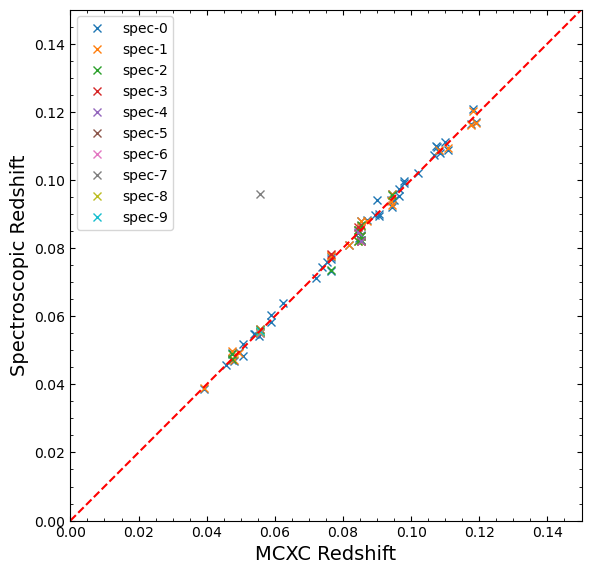

In [9]:
lims = [0, 0.15]

plt.figure(figsize=(6, 6))
plt.gca().set_aspect(1)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.plot(og_zs, bcg1_all_spec_zs, 'x', label=['spec-{}'.format(ind) for ind in range(bcg1_all_spec_zs.shape[1])])
plt.plot(lims, lims, color='red', linestyle='dashed')

plt.xlim(lims)
plt.ylim(lims)

plt.ylabel("Spectroscopic Redshift", fontsize=14)
plt.xlabel("MCXC Redshift", fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

Calculate and plot the ratios as well, as another way of interpreting the same comparison:

In [10]:
bcg1_specz_ogz_rat = (bcg1_all_spec_zs.values / og_zs[..., None])

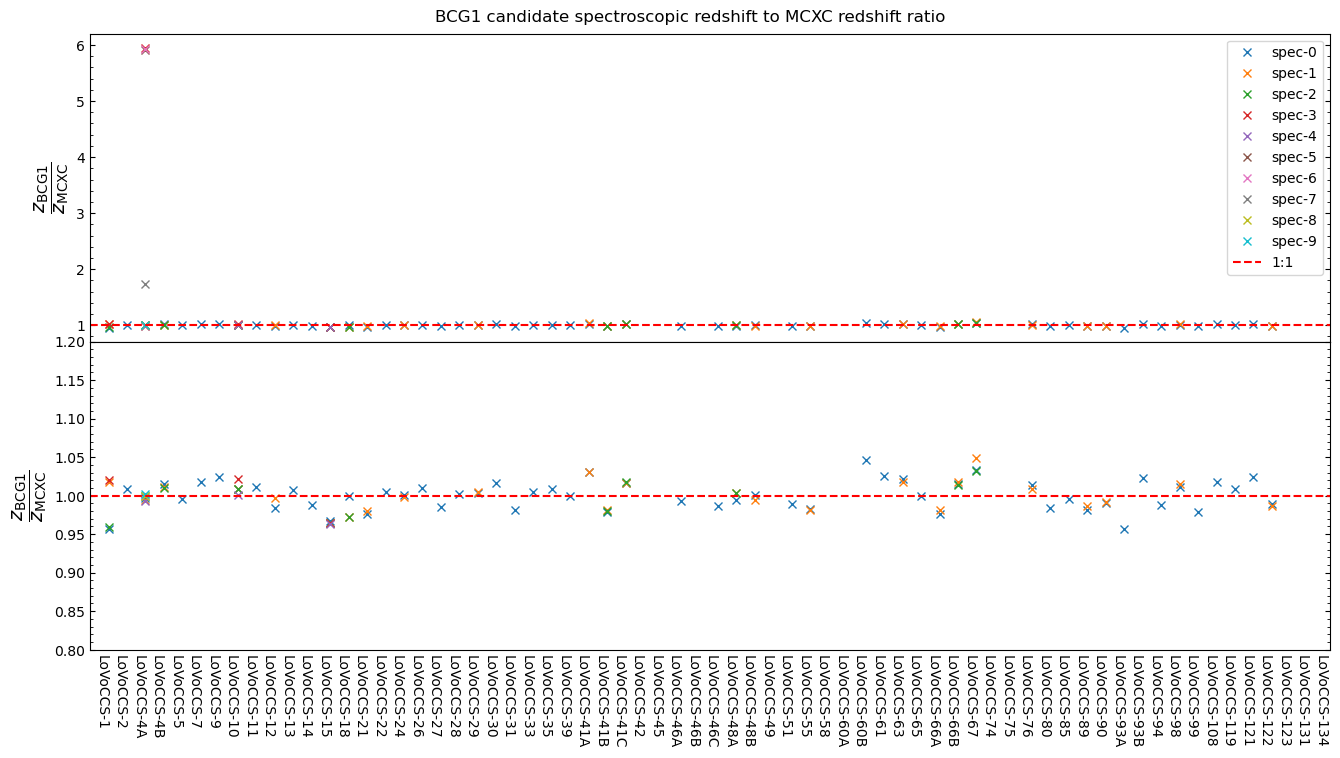

In [11]:
fig, ax_arr = plt.subplots(nrows=2, figsize=(16, 8), sharex='col')
fig.subplots_adjust(hspace=0)

ax_arr[0].minorticks_on()
ax_arr[0].tick_params(which="both", direction='in', top=False, right=True, bottom=False)

ax_arr[0].plot(range(0, len(bcg1_specz_ogz_rat)), bcg1_specz_ogz_rat, 'x', 
               label=['spec-{}'.format(ind) for ind in range(bcg1_all_spec_zs.shape[1])])
ax_arr[0].axhline(1, color='red', linestyle='dashed', label='1:1')
ax_arr[0].set_ylabel(r"$\dfrac{z_{\rm{BCG1}}}{z_{\rm{MCXC}}}$", fontsize=14)
ax_arr[0].legend()

ax_arr[1].minorticks_on()
ax_arr[1].tick_params(which="both", direction='in', top=False, right=True, bottom=False)
ax_arr[1].plot(range(0, len(bcg1_specz_ogz_rat)), bcg1_specz_ogz_rat, 'x')
ax_arr[1].axhline(1, color='red', linestyle='dashed')
ax_arr[1].set_ylabel(r"$\dfrac{z_{\rm{BCG1}}}{z_{\rm{MCXC}}}$", fontsize=14)
ax_arr[1].set_ylim(0.8, 1.2)

ax_arr[1].set_xlim(-1)
ax_arr[1].set_xticks(range(0, len(bcg1_specz_ogz_rat)))
ax_arr[1].set_xticklabels(spec_info.index.values)
for label in ax_arr[1].get_xticklabels(which='both'):
    label.set(y=label.get_position()[1], rotation=-90, horizontalalignment='right')

plt.suptitle("BCG1 candidate spectroscopic redshift to MCXC redshift ratio", y=0.91)
# plt.tight_layout()
plt.show()

#### Looking at the worst offender

From this figure, it seems that some of the spectroscopic redshifts we identified for the BCG1 candidate of LoVoCCS-4A (Abell 85) are factors of ~1.8-6 larger than the MCXC redshift - given how well studied Abell 85 is, it is likely that those outliers are simply not associated with the BCG candidate, or their measurement had issues, but we will take a look at their sources to check:

In [12]:
spec_info.loc['LoVoCCS-4A'].loc(axis=0)['BCG1', :, 'z'] / samp.loc['LoVoCCS-4A']['redshift']

BCG1  spec0  z    0.997455
      spec1  z    0.993841
      spec2  z    0.999789
      spec3  z    5.953413
      spec4  z    0.993305
      spec5  z    5.905478
      spec6  z    5.922654
      spec7  z    1.727495
      spec8  z    0.998931
      spec9  z    1.001602
Name: LoVoCCS-4A, dtype: object

Fetching the spectral identification history for the BCG1 candidate for LoVoCCS-4A:

In [13]:
lovoccs4a_bcg_spec = cur_history['bcg_spec_identification']['LoVoCCS-4A']['BCG1']['identified_spectra']

Examining the entries for the spectra that are the sources of the outlier redshifts:

In [14]:
lovoccs4a_bcg_spec['spec3']

{'spec_id': 5673270,
 'rcsedv2_spec_id': 5673270,
 'survey': 'fast',
 'survey_spec_id': {'obs_date': '2003',
  'obs_dataset_id': '2003.092',
  'fast_dataset_spec_id': '0108.sn2003ic.ms.fits'},
 'ra': 10.459291458129883,
 'dec': -9.305277824401855,
 'approx_aperture_arcsec': 10.0,
 'z': 0.33041444420814514,
 'z_err': None,
 'z_quality': None}

In [15]:
lovoccs4a_bcg_spec['spec5']

{'spec_id': 5673367,
 'rcsedv2_spec_id': 5673367,
 'survey': 'fast',
 'survey_spec_id': {'obs_date': '2003',
  'obs_dataset_id': '2003.0927',
  'fast_dataset_spec_id': '0087.sn2003ic.ms.fits'},
 'ra': 10.459291458129883,
 'dec': -9.305277824401855,
 'approx_aperture_arcsec': 10.0,
 'z': 0.32775405049324036,
 'z_err': None,
 'z_quality': None}

In [16]:
lovoccs4a_bcg_spec['spec6']

{'spec_id': 5673397,
 'rcsedv2_spec_id': 5673397,
 'survey': 'fast',
 'survey_spec_id': {'obs_date': '2003',
  'obs_dataset_id': '2003.0928',
  'fast_dataset_spec_id': '0109.sn2003ic.ms.fits'},
 'ra': 10.459291458129883,
 'dec': -9.305277824401855,
 'approx_aperture_arcsec': 10.0,
 'z': 0.3287072777748108,
 'z_err': None,
 'z_quality': None}

In [17]:
lovoccs4a_bcg_spec['spec7']

{'spec_id': 5673477,
 'rcsedv2_spec_id': 5673477,
 'survey': 'fast',
 'survey_spec_id': {'obs_date': '2003',
  'obs_dataset_id': '2003.093',
  'fast_dataset_spec_id': '0065.sn2003ic.ms.fits'},
 'ra': 10.459291458129883,
 'dec': -9.305277824401855,
 'approx_aperture_arcsec': 10.0,
 'z': 0.09587594866752625,
 'z_err': None,
 'z_quality': None}

**We find that they are all FAST spectra, are all a little offset from the central coordinates of the BCG, which may be the cause of the discrepant redshift measurements.** It is difficult to identify another source that they could have been targeting, but either way we can rest assured that the other spectroscopic redshift measurements we have identified are more likely to be correct than these.

### BCG2 redshifts compared to MCXC

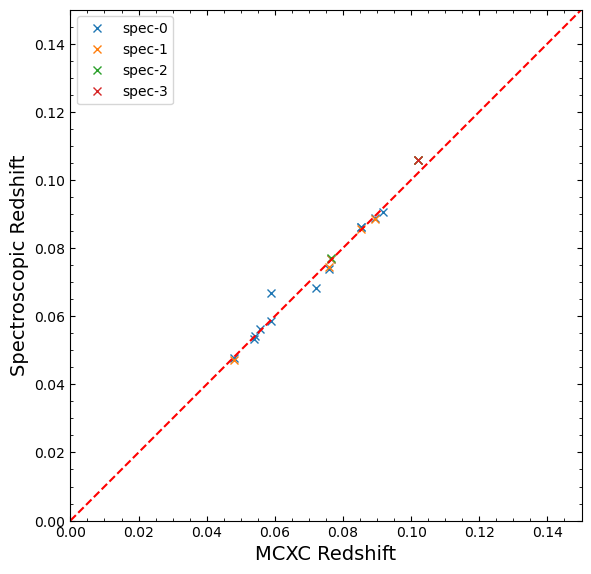

In [18]:
lims = [0, 0.15]

plt.figure(figsize=(6, 6))
plt.gca().set_aspect(1)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.plot(og_zs, bcg2_all_spec_zs, 'x', label=['spec-{}'.format(ind) for ind in range(bcg2_all_spec_zs.shape[1])])
plt.plot(lims, lims, color='red', linestyle='dashed')

plt.xlim(lims)
plt.ylim(lims)

plt.ylabel("Spectroscopic Redshift", fontsize=14)
plt.xlabel("MCXC Redshift", fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

Calculate and plot the ratios as well, as another way of interpreting the same comparison:

In [19]:
bcg2_specz_ogz_rat = (bcg2_all_spec_zs.values / og_zs[..., None])

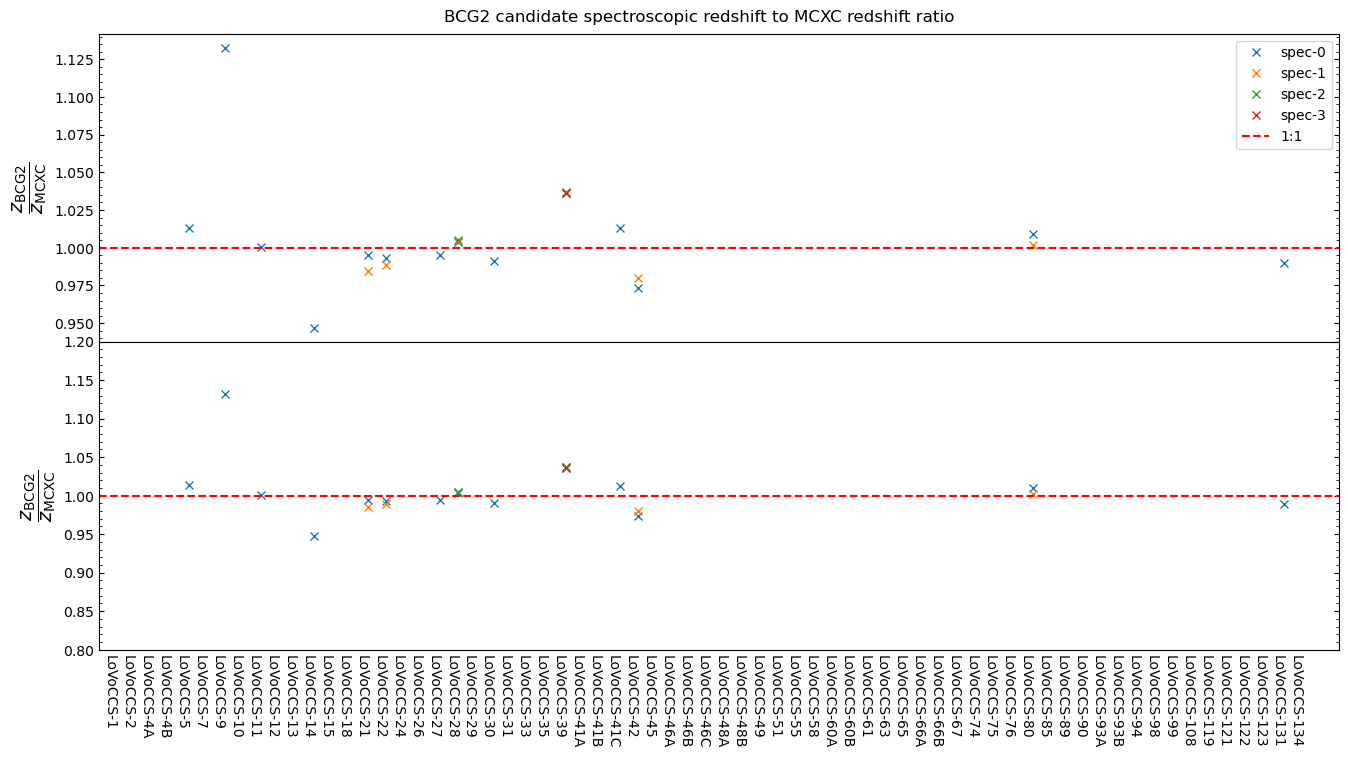

In [20]:
fig, ax_arr = plt.subplots(nrows=2, figsize=(16, 8), sharex='col')
fig.subplots_adjust(hspace=0)

ax_arr[0].minorticks_on()
ax_arr[0].tick_params(which="both", direction='in', top=False, right=True, bottom=False)

ax_arr[0].plot(range(0, len(bcg2_specz_ogz_rat)), bcg2_specz_ogz_rat, 'x', 
               label=['spec-{}'.format(ind) for ind in range(bcg2_all_spec_zs.shape[1])])
ax_arr[0].axhline(1, color='red', linestyle='dashed', label='1:1')
ax_arr[0].set_ylabel(r"$\dfrac{z_{\rm{BCG2}}}{z_{\rm{MCXC}}}$", fontsize=14)
ax_arr[0].legend()

ax_arr[1].minorticks_on()
ax_arr[1].tick_params(which="both", direction='in', top=False, right=True, bottom=False)
ax_arr[1].plot(range(0, len(bcg2_specz_ogz_rat)), bcg2_specz_ogz_rat, 'x')
ax_arr[1].axhline(1, color='red', linestyle='dashed')
ax_arr[1].set_ylabel(r"$\dfrac{z_{\rm{BCG2}}}{z_{\rm{MCXC}}}$", fontsize=14)
ax_arr[1].set_ylim(0.8, 1.2)

ax_arr[1].set_xlim(-1)
ax_arr[1].set_xticks(range(0, len(bcg2_specz_ogz_rat)))
ax_arr[1].set_xticklabels(spec_info.index.values)
for label in ax_arr[1].get_xticklabels(which='both'):
    label.set(y=label.get_position()[1], rotation=-90, horizontalalignment='right')

plt.suptitle("BCG2 candidate spectroscopic redshift to MCXC redshift ratio", y=0.91)
# plt.tight_layout()
plt.show()

### BCG3 redshifts compared to MCXC

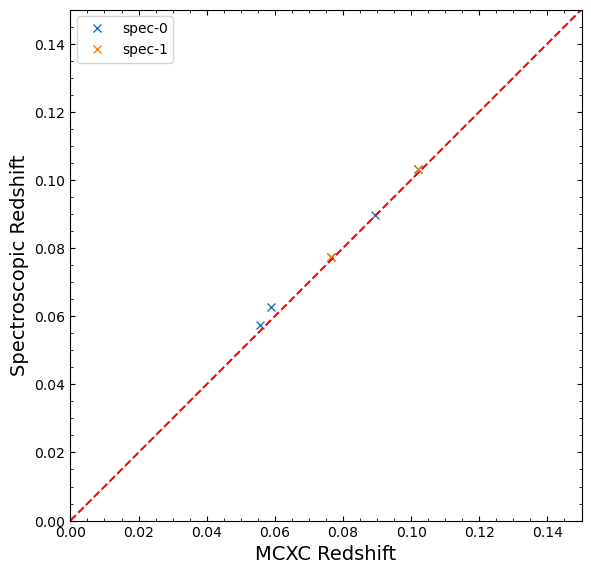

In [21]:
lims = [0, 0.15]

plt.figure(figsize=(6, 6))
plt.gca().set_aspect(1)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.plot(og_zs, bcg3_all_spec_zs, 'x', label=['spec-{}'.format(ind) for ind in range(bcg3_all_spec_zs.shape[1])])
plt.plot(lims, lims, color='red', linestyle='dashed')

plt.xlim(lims)
plt.ylim(lims)

plt.ylabel("Spectroscopic Redshift", fontsize=14)
plt.xlabel("MCXC Redshift", fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

Calculate and plot the ratios as well, as another way of interpreting the same comparison:

In [22]:
bcg3_specz_ogz_rat = (bcg3_all_spec_zs.values / og_zs[..., None])

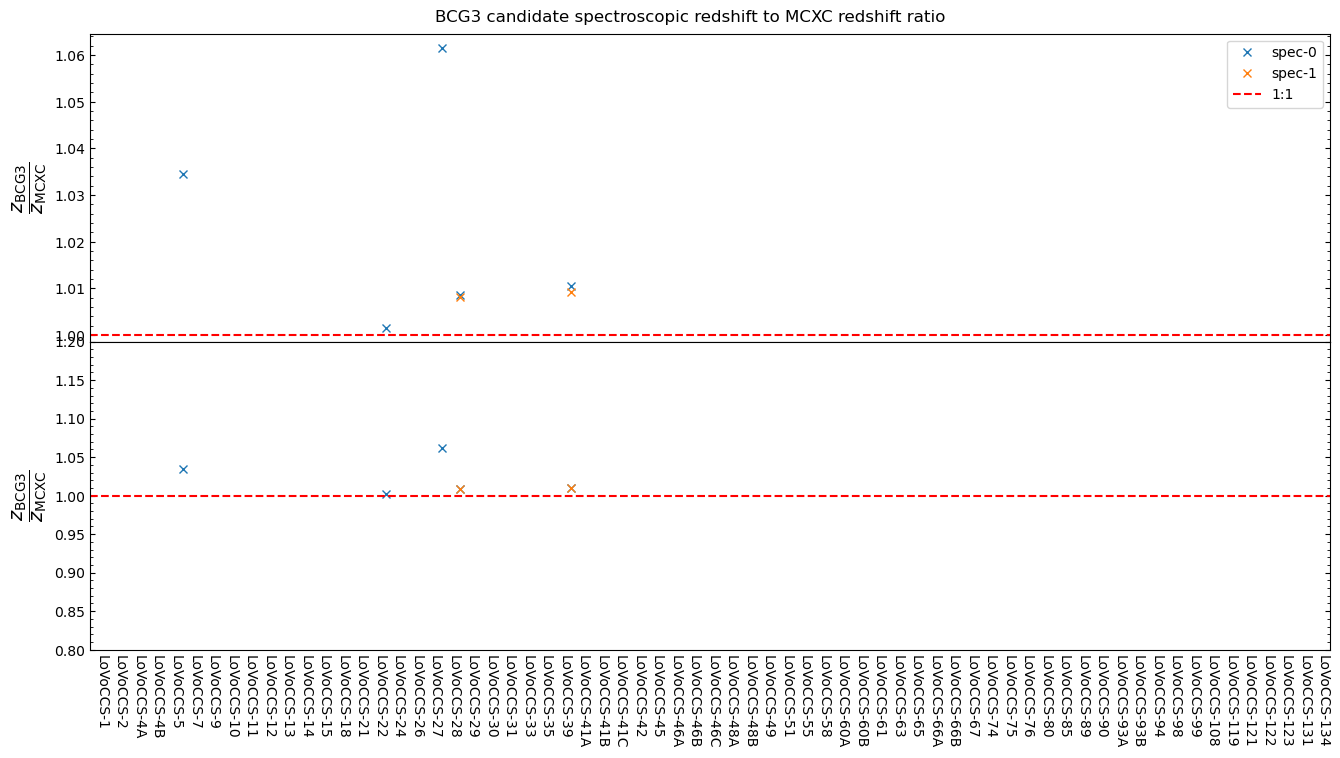

In [23]:
fig, ax_arr = plt.subplots(nrows=2, figsize=(16, 8), sharex='col')
fig.subplots_adjust(hspace=0)

ax_arr[0].minorticks_on()
ax_arr[0].tick_params(which="both", direction='in', top=False, right=True, bottom=False)

ax_arr[0].plot(range(0, len(bcg3_specz_ogz_rat)), bcg3_specz_ogz_rat, 'x', 
               label=['spec-{}'.format(ind) for ind in range(bcg3_all_spec_zs.shape[1])])
ax_arr[0].axhline(1, color='red', linestyle='dashed', label='1:1')
ax_arr[0].set_ylabel(r"$\dfrac{z_{\rm{BCG3}}}{z_{\rm{MCXC}}}$", fontsize=14)
ax_arr[0].legend()

ax_arr[1].minorticks_on()
ax_arr[1].tick_params(which="both", direction='in', top=False, right=True, bottom=False)
ax_arr[1].plot(range(0, len(bcg3_specz_ogz_rat)), bcg3_specz_ogz_rat, 'x')
ax_arr[1].axhline(1, color='red', linestyle='dashed')
ax_arr[1].set_ylabel(r"$\dfrac{z_{\rm{BCG3}}}{z_{\rm{MCXC}}}$", fontsize=14)
ax_arr[1].set_ylim(0.8, 1.2)

ax_arr[1].set_xlim(-1)
ax_arr[1].set_xticks(range(0, len(bcg3_specz_ogz_rat)))
ax_arr[1].set_xticklabels(spec_info.index.values)
for label in ax_arr[1].get_xticklabels(which='both'):
    label.set(y=label.get_position()[1], rotation=-90, horizontalalignment='right')

plt.suptitle("BCG3 candidate spectroscopic redshift to MCXC redshift ratio", y=0.91)
# plt.tight_layout()
plt.show()

### BCG4 redshifts compared to MCXC

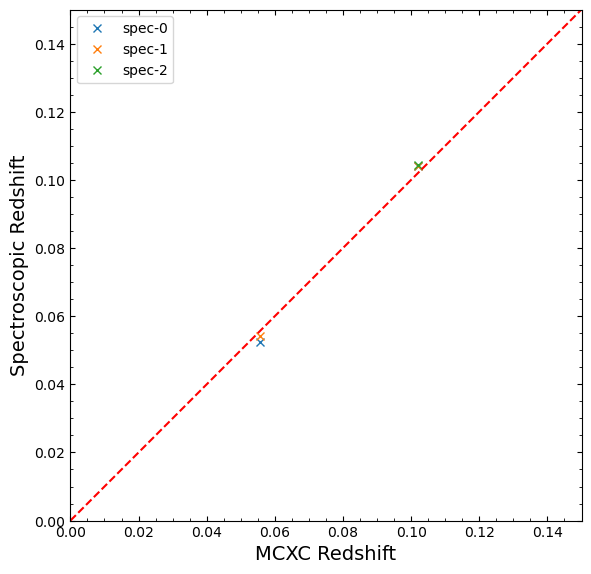

In [24]:
lims = [0, 0.15]

plt.figure(figsize=(6, 6))
plt.gca().set_aspect(1)
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True)

plt.plot(og_zs, bcg4_all_spec_zs, 'x', label=['spec-{}'.format(ind) for ind in range(bcg4_all_spec_zs.shape[1])])

plt.plot(lims, lims, color='red', linestyle='dashed')

plt.xlim(lims)
plt.ylim(lims)

plt.ylabel("Spectroscopic Redshift", fontsize=14)
plt.xlabel("MCXC Redshift", fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

Calculate and plot the ratios as well, as another way of interpreting the same comparison:

In [25]:
bcg4_specz_ogz_rat = (bcg4_all_spec_zs.values / og_zs[..., None])

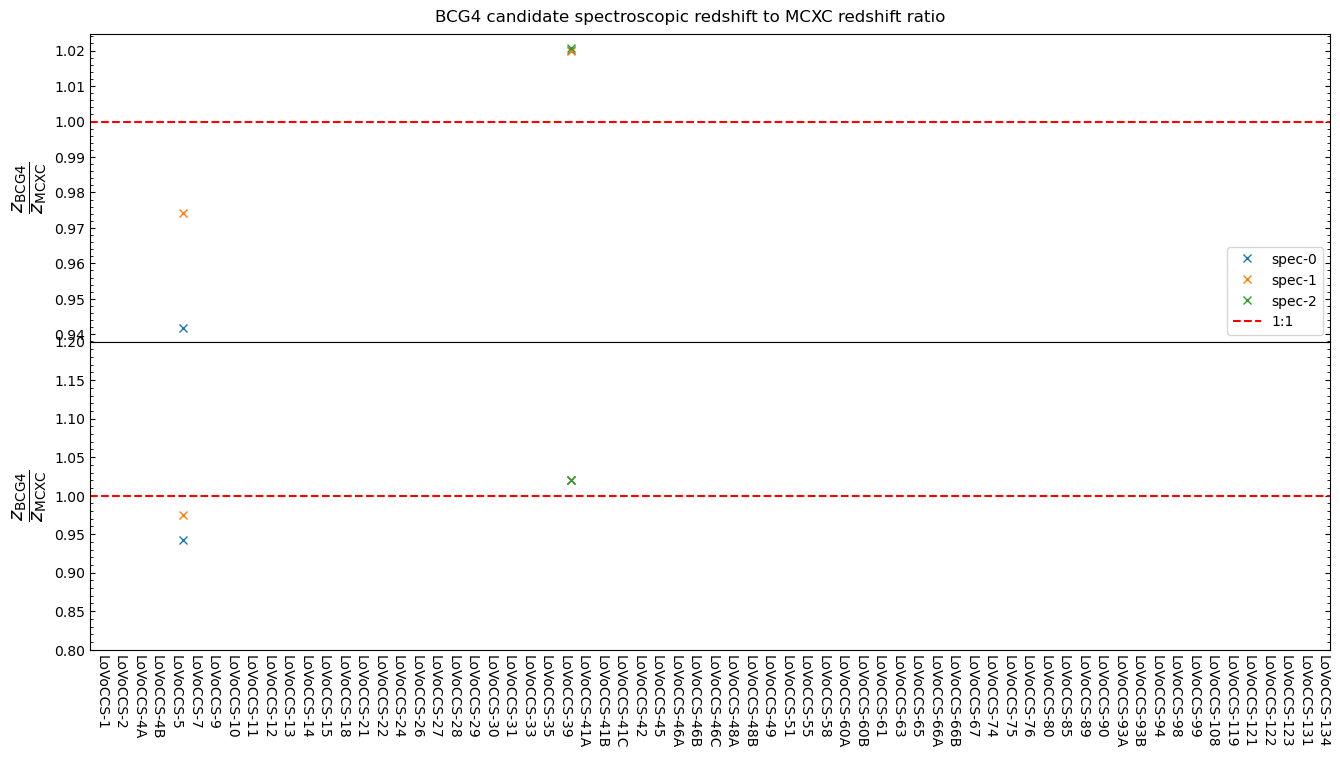

In [26]:
fig, ax_arr = plt.subplots(nrows=2, figsize=(16, 8), sharex='col')
fig.subplots_adjust(hspace=0)

ax_arr[0].minorticks_on()
ax_arr[0].tick_params(which="both", direction='in', top=False, right=True, bottom=False)

ax_arr[0].plot(range(0, len(bcg4_specz_ogz_rat)), bcg4_specz_ogz_rat, 'x', 
               label=['spec-{}'.format(ind) for ind in range(bcg4_all_spec_zs.shape[1])])
ax_arr[0].axhline(1, color='red', linestyle='dashed', label='1:1')
ax_arr[0].set_ylabel(r"$\dfrac{z_{\rm{BCG4}}}{z_{\rm{MCXC}}}$", fontsize=14)
ax_arr[0].legend()

ax_arr[1].minorticks_on()
ax_arr[1].tick_params(which="both", direction='in', top=False, right=True, bottom=False)
ax_arr[1].plot(range(0, len(bcg4_specz_ogz_rat)), bcg4_specz_ogz_rat, 'x')
ax_arr[1].axhline(1, color='red', linestyle='dashed')
ax_arr[1].set_ylabel(r"$\dfrac{z_{\rm{BCG4}}}{z_{\rm{MCXC}}}$", fontsize=14)
ax_arr[1].set_ylim(0.8, 1.2)

ax_arr[1].set_xlim(-1)
ax_arr[1].set_xticks(range(0, len(bcg4_specz_ogz_rat)))
ax_arr[1].set_xticklabels(spec_info.index.values)
for label in ax_arr[1].get_xticklabels(which='both'):
    label.set(y=label.get_position()[1], rotation=-90, horizontalalignment='right')

plt.suptitle("BCG4 candidate spectroscopic redshift to MCXC redshift ratio", y=0.91)
# plt.tight_layout()
plt.show()

## Which BCG candidates are missing spec-zs from the BCG-Ident tool?

### BCG1 candidates

In [27]:
bcg1_file_path = 'outputs/literature_specz_for_cands_without/bcg1_cand_notoolz_litspecz.json'
if os.path.exists(bcg1_file_path):
    raise FileExistsError("Don't want to overwrite the existing note file, remove it or change the name before running again.")

In [28]:
bcg1_speczs = spec_info.loc(axis=1)['BCG1', :, 'z']['BCG1']
bcg1_no_specz = bcg1_speczs[np.isnan(bcg1_speczs['spec0']['z'])]
print(len(bcg1_no_specz), 'of', len(bcg1_speczs), 'BCG1 candidates have no spec-z')
bcg1_no_specz

11 of 67 BCG1 candidates have no spec-z


,spec0,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9
,z,z,z,z,z,z,z,z,z,z
name,,,,,,,,,,
LoVoCCS-42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-46B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-60A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LoVoCCS-75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Searching for missing spec-zs from other sources:

In [29]:
bcg1_missing_speczs = {n: {'z': None, 'z_err': None, 'source': None, 'unique_id': None, 'em_line': None, 'notes': ""} 
                       for n in bcg1_no_specz.index.values}

cur_miss_name = 'LoVoCCS-42'
bcg1_missing_speczs[cur_miss_name]['z'] = (22691/299792)
bcg1_missing_speczs[cur_miss_name]['z_err'] = (48/299792)
bcg1_missing_speczs[cur_miss_name]['source'] = "ENACS"
bcg1_missing_speczs[cur_miss_name]['unique_id'] = "ACO3822-Seq52"

cur_miss_name = 'LoVoCCS-45'
bcg1_missing_speczs[cur_miss_name]['notes'] = "May have SOAR Goodman spectra"

cur_miss_name = 'LoVoCCS-46B'
bcg1_missing_speczs[cur_miss_name]['z'] = 0.093288
bcg1_missing_speczs[cur_miss_name]['z_err'] = 0.000103
bcg1_missing_speczs[cur_miss_name]['source'] = "https://ui.adsabs.harvard.edu/abs/1991AJ....102.1581B/abstract"
bcg1_missing_speczs[cur_miss_name]['unique_id'] = "2221—0146A"

cur_miss_name = 'LoVoCCS-49'
bcg1_missing_speczs[cur_miss_name]['z'] = 0.11985
bcg1_missing_speczs[cur_miss_name]['z_err'] = None
bcg1_missing_speczs[cur_miss_name]['source'] = "https://ui.adsabs.harvard.edu/abs/2016MNRAS.460.1758H/abstract"
bcg1_missing_speczs[cur_miss_name]['unique_id'] = "A1348"
bcg1_missing_speczs[cur_miss_name]['notes'] = ("Mixed picture in NED - has entries at z=0.055 and 0.1195. This "
                                               "redshift seems reliable, it is the median z from fitting the Hα-[NII] "
                                               "complex from VIMOS data. ALSO HAS GOODMAN SPECTRA WE TOOK")

cur_miss_name = 'LoVoCCS-58'
bcg1_missing_speczs[cur_miss_name]['z'] = (26928/299792)
bcg1_missing_speczs[cur_miss_name]['z_err'] = (59/299792)
bcg1_missing_speczs[cur_miss_name]['source'] = "https://ui.adsabs.harvard.edu/abs/2009A%26A...499..357G/abstract"
bcg1_missing_speczs[cur_miss_name]['unique_id'] = None

cur_miss_name = 'LoVoCCS-60A'
bcg1_missing_speczs[cur_miss_name]['notes'] = "Not much on NED, one photometric z=0.08532, and one alleged specz=0.137 (don't believe it)"

cur_miss_name = 'LoVoCCS-74'
bcg1_missing_speczs[cur_miss_name]['z'] = (32771/299792)
bcg1_missing_speczs[cur_miss_name]['z_err'] = (43/299792)
bcg1_missing_speczs[cur_miss_name]['source'] = "REFLEX spectroscopic redshifts"
bcg1_missing_speczs[cur_miss_name]['unique_id'] = None
bcg1_missing_speczs[cur_miss_name]['notes'] = ""

cur_miss_name = 'LoVoCCS-75'
bcg1_missing_speczs[cur_miss_name]['z'] = (33270/299792)
bcg1_missing_speczs[cur_miss_name]['z_err'] = (63/299792)
bcg1_missing_speczs[cur_miss_name]['source'] = "https://ui.adsabs.harvard.edu/abs/1995ApJS...96..343Q/abstract"
bcg1_missing_speczs[cur_miss_name]['unique_id'] = None
bcg1_missing_speczs[cur_miss_name]['notes'] = ""

cur_miss_name = 'LoVoCCS-123'
bcg1_missing_speczs[cur_miss_name]['z'] = (17194/299792)
bcg1_missing_speczs[cur_miss_name]['z_err'] = (60/299792)
bcg1_missing_speczs[cur_miss_name]['source'] = "https://ui.adsabs.harvard.edu/abs/2003MNRAS.339..652K/abstract"
bcg1_missing_speczs[cur_miss_name]['unique_id'] = None
bcg1_missing_speczs[cur_miss_name]['notes'] = ""

cur_miss_name = 'LoVoCCS-131'
bcg1_missing_speczs[cur_miss_name]['z'] = 0.0921
bcg1_missing_speczs[cur_miss_name]['z_err'] = 0.0002
bcg1_missing_speczs[cur_miss_name]['source'] = "https://ui.adsabs.harvard.edu/abs/1995AJ....109...14O/abstract"
bcg1_missing_speczs[cur_miss_name]['unique_id'] = "0908-103"
bcg1_missing_speczs[cur_miss_name]['notes'] = "Ha+NII < 8.7x10^40 ergs^-1; OII < 1.3x10^40 ergs^-1. Marked em line as False however"
bcg1_missing_speczs[cur_miss_name]['em_line'] = False

cur_miss_name = 'LoVoCCS-134'
bcg1_missing_speczs[cur_miss_name]['z'] = (22709/3e+5)
bcg1_missing_speczs[cur_miss_name]['z_err'] = (66/3e+5)
bcg1_missing_speczs[cur_miss_name]['source'] = "ENACS"
bcg1_missing_speczs[cur_miss_name]['unique_id'] = "ACO3825-Seq52"

How many of the BCG1 candidates with missing spectroscopic redshifts now have one?

In [30]:
bcg1_num_found = sum([miss_spec_info['z'] is not None for n, miss_spec_info in bcg1_missing_speczs.items()])
print("Identified spec-zs for", bcg1_num_found, 'of', len(bcg1_no_specz), 'BCG1 candidates without spec-z from the tool')

Identified spec-zs for 9 of 11 BCG1 candidates without spec-z from the tool


Which still don't have one?

In [31]:
[n for n, miss_spec_info in bcg1_missing_speczs.items() if miss_spec_info['z'] is None]

['LoVoCCS-45', 'LoVoCCS-60A']

Saving the notes:

In [32]:
with open(bcg1_file_path, 'w') as noteo:
    json.dump(bcg1_missing_speczs, noteo)

### BCG2 candidates

In [33]:
bcg2_file_path = 'outputs/literature_specz_for_cands_without/bcg2_cand_notoolz_litspecz.json'
if os.path.exists(bcg2_file_path):
    raise FileExistsError("Don't want to overwrite the existing note file, remove it or change the name before running again.")

In [34]:
with_bcg2 = bcg_samp[(~np.isnan(bcg_samp['BCG2_desi-ls_ra'])) | (~np.isnan(bcg_samp['BCG2_lovoccs_ra']))]['cluster_name'].values
with_bcg2

array(['LoVoCCS-5', 'LoVoCCS-9', 'LoVoCCS-11', 'LoVoCCS-13', 'LoVoCCS-14',
       'LoVoCCS-21', 'LoVoCCS-22', 'LoVoCCS-24', 'LoVoCCS-27',
       'LoVoCCS-28', 'LoVoCCS-30', 'LoVoCCS-31', 'LoVoCCS-33',
       'LoVoCCS-39', 'LoVoCCS-41C', 'LoVoCCS-42', 'LoVoCCS-45',
       'LoVoCCS-55', 'LoVoCCS-58', 'LoVoCCS-60A', 'LoVoCCS-61',
       'LoVoCCS-80', 'LoVoCCS-108', 'LoVoCCS-131', 'LoVoCCS-134'],
      dtype=object)

In [35]:
bcg2_speczs = spec_info.loc[with_bcg2].loc(axis=1)['BCG2', :, 'z']['BCG2']
bcg2_no_specz = bcg2_speczs[np.isnan(bcg2_speczs['spec0']['z'])]
print(len(bcg2_no_specz), 'of', len(bcg2_speczs), 'BCG2 candidates have no spec-z')
bcg2_no_specz

11 of 25 BCG2 candidates have no spec-z


,spec0,spec1,spec2,spec3
,z,z,z,z
name,,,,
LoVoCCS-13,NaN,NaN,NaN,NaN
LoVoCCS-24,NaN,NaN,NaN,NaN
LoVoCCS-31,NaN,NaN,NaN,NaN
LoVoCCS-33,NaN,NaN,NaN,NaN
LoVoCCS-45,NaN,NaN,NaN,NaN
LoVoCCS-55,NaN,NaN,NaN,NaN
LoVoCCS-58,NaN,NaN,NaN,NaN
LoVoCCS-60A,NaN,NaN,NaN,NaN


Searching for missing spec-zs from other sources:

In [36]:
bcg2_missing_speczs = {n: {'z': None, 'z_err': None, 'source': None, 'unique_id': None, 'em_line': None, 'notes': ""} 
                       for n in bcg2_no_specz.index.values}

cur_miss_name = 'LoVoCCS-13'
bcg2_missing_speczs[cur_miss_name]['z'] = (22616/299792)
bcg2_missing_speczs[cur_miss_name]['z_err'] = (81/299792)
bcg2_missing_speczs[cur_miss_name]['source'] = "ENACS"
bcg2_missing_speczs[cur_miss_name]['unique_id'] = "ACO3112-Seq34"
bcg2_missing_speczs[cur_miss_name]['notes'] = ""

cur_miss_name = 'LoVoCCS-24'
bcg2_missing_speczs[cur_miss_name]['z'] = (27879/299792)
bcg2_missing_speczs[cur_miss_name]['z_err'] = (57/299792)
bcg2_missing_speczs[cur_miss_name]['source'] = "ENACS"
bcg2_missing_speczs[cur_miss_name]['unique_id'] = "ACO3921-Seq13"
bcg2_missing_speczs[cur_miss_name]['notes'] = ""

cur_miss_name = 'LoVoCCS-31'
bcg2_missing_speczs[cur_miss_name]['notes'] = "Only a photometric redshift on NED"

cur_miss_name = 'LoVoCCS-33'
bcg2_missing_speczs[cur_miss_name]['notes'] = "No redshifts on NED at all"

cur_miss_name = 'LoVoCCS-45'
bcg2_missing_speczs[cur_miss_name]['z'] = (35458/299792)
bcg2_missing_speczs[cur_miss_name]['z_err'] = (80/299792)
bcg2_missing_speczs[cur_miss_name]['source'] = "REFLEX spectroscopic redshifts"
bcg2_missing_speczs[cur_miss_name]['unique_id'] = None
bcg2_missing_speczs[cur_miss_name]['notes'] = ""

cur_miss_name = 'LoVoCCS-55'
bcg2_missing_speczs[cur_miss_name]['notes'] = "Only a photometric redshift on NED"

cur_miss_name = 'LoVoCCS-58'
bcg2_missing_speczs[cur_miss_name]['source'] = "https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.3013Y/abstract"
bcg2_missing_speczs[cur_miss_name]['notes'] = "Paper has a redshift of z=0.191700 (per NED), but can't find source"

cur_miss_name = 'LoVoCCS-60A'
bcg2_missing_speczs[cur_miss_name]['notes'] = "Not much on NED, one photometric z=0.099018"

cur_miss_name = 'LoVoCCS-61'
bcg2_missing_speczs[cur_miss_name]['z'] = 0.1096806
bcg2_missing_speczs[cur_miss_name]['z_err'] = 9.88e-06
bcg2_missing_speczs[cur_miss_name]['source'] = "https://ui.adsabs.harvard.edu/abs/2019ApJS..240...39G/abstract"
bcg2_missing_speczs[cur_miss_name]['unique_id'] = None
bcg2_missing_speczs[cur_miss_name]['em_line'] = True
bcg2_missing_speczs[cur_miss_name]['notes'] = ("HAVEN'T INSPECTED MYSELF, but the catalog notes the following spectral "
                                               "features - Hb ab; Mg I (b); Na I (D); Ha ab")

cur_miss_name = 'LoVoCCS-108'
bcg2_missing_speczs[cur_miss_name]['notes'] = "No redshifts on NED at all"

cur_miss_name = 'LoVoCCS-134'
bcg2_missing_speczs[cur_miss_name]['z'] = (22577/299792)
bcg2_missing_speczs[cur_miss_name]['z_err'] = (66/299792)
bcg2_missing_speczs[cur_miss_name]['source'] = "ENACS"
bcg2_missing_speczs[cur_miss_name]['unique_id'] = "ACO3825-Seq55"
bcg2_missing_speczs[cur_miss_name]['notes'] = ""

How many of the BCG2 candidates with missing spectroscopic redshifts now have one?

In [37]:
bcg2_num_found = sum([miss_spec_info['z'] is not None for n, miss_spec_info in bcg2_missing_speczs.items()])
print("Identified spec-zs for", bcg2_num_found, 'of', len(bcg2_no_specz), 'BCG2 candidates without spec-z from the tool')

Identified spec-zs for 5 of 11 BCG2 candidates without spec-z from the tool


Which still don't have one?

In [38]:
[n for n, miss_spec_info in bcg2_missing_speczs.items() if miss_spec_info['z'] is None]

['LoVoCCS-31',
 'LoVoCCS-33',
 'LoVoCCS-55',
 'LoVoCCS-58',
 'LoVoCCS-60A',
 'LoVoCCS-108']

Saving the notes:

In [39]:
with open(bcg2_file_path, 'w') as noteo:
    json.dump(bcg2_missing_speczs, noteo)

### BCG3 candidates

In [40]:
bcg3_file_path = 'outputs/literature_specz_for_cands_without/bcg3_cand_notoolz_litspecz.json'
if os.path.exists(bcg3_file_path):
    raise FileExistsError("Don't want to overwrite the existing note file, remove it or change the name before running again.")

In [41]:
with_bcg3 = bcg_samp[~np.isnan(bcg_samp['BCG3_desi-ls_ra'])]['cluster_name'].values
with_bcg3

array(['LoVoCCS-5', 'LoVoCCS-22', 'LoVoCCS-27', 'LoVoCCS-28',
       'LoVoCCS-39', 'LoVoCCS-55', 'LoVoCCS-58', 'LoVoCCS-134'],
      dtype=object)

In [42]:
bcg3_speczs = spec_info.loc[with_bcg3].loc(axis=1)['BCG3', :, 'z']['BCG3']
bcg3_no_specz = bcg3_speczs[np.isnan(bcg3_speczs['spec0']['z'])]
print(len(bcg3_no_specz), 'of', len(bcg3_speczs), 'BCG3 candidates have no spec-z')
bcg3_no_specz

3 of 8 BCG3 candidates have no spec-z


,spec0,spec1
,z,z
name,,
LoVoCCS-55,NaN,NaN
LoVoCCS-58,NaN,NaN
LoVoCCS-134,NaN,NaN


Searching for missing spec-zs from other sources:

In [43]:
bcg3_missing_speczs = {n: {'z': None, 'z_err': None, 'source': None, 'unique_id': None, 'em_line': None, 'notes': ""} 
                       for n in bcg3_no_specz.index.values}

cur_miss_name = 'LoVoCCS-55'
bcg3_missing_speczs[cur_miss_name]['notes'] = ("Not much on NED, one photometric z=0.107190 from "
                                               "https://ui.adsabs.harvard.edu/abs/2014ApJS..210....9B/abstract")

cur_miss_name = 'LoVoCCS-58'
bcg3_missing_speczs[cur_miss_name]['z'] = (26858/299792)
bcg3_missing_speczs[cur_miss_name]['z_err'] = (47/299792)
bcg3_missing_speczs[cur_miss_name]['source'] = "REFLEX spectroscopic redshifts"
bcg3_missing_speczs[cur_miss_name]['unique_id'] = None
bcg3_missing_speczs[cur_miss_name]['notes'] = ""

cur_miss_name = 'LoVoCCS-134'
bcg3_missing_speczs[cur_miss_name]['z'] = (21276/299792)
bcg3_missing_speczs[cur_miss_name]['z_err'] = (54/299792)
bcg3_missing_speczs[cur_miss_name]['source'] = "ENACS"
bcg3_missing_speczs[cur_miss_name]['unique_id'] = "ACO3825-Seq47"
bcg3_missing_speczs[cur_miss_name]['notes'] = ""

How many of the BCG3 candidates with missing spectroscopic redshifts now have one?

In [44]:
bcg3_num_found = sum([miss_spec_info['z'] is not None for n, miss_spec_info in bcg3_missing_speczs.items()])
print("Identified spec-zs for", bcg3_num_found, 'of', len(bcg3_no_specz), 'BCG3 candidates without spec-z from the tool')

Identified spec-zs for 2 of 3 BCG3 candidates without spec-z from the tool


Which still don't have one?

In [45]:
[n for n, miss_spec_info in bcg3_missing_speczs.items() if miss_spec_info['z'] is None]

['LoVoCCS-55']

Saving the notes:

In [46]:
with open(bcg3_file_path, 'w') as noteo:
    json.dump(bcg3_missing_speczs, noteo)

### BCG4 candidates

In [47]:
bcg4_file_path = 'outputs/literature_specz_for_cands_without/bcg4_cand_notoolz_litspecz.json'
if os.path.exists(bcg4_file_path):
    raise FileExistsError("Don't want to overwrite the existing note file, remove it or change the name before running again.")

In [48]:
with_bcg4 = bcg_samp[~np.isnan(bcg_samp['BCG4_desi-ls_ra'])]['cluster_name'].values
with_bcg4

array(['LoVoCCS-5', 'LoVoCCS-39', 'LoVoCCS-55'], dtype=object)

In [49]:
bcg4_speczs = spec_info.loc[with_bcg4].loc(axis=1)['BCG4', :, 'z']['BCG4']
bcg4_no_specz = bcg4_speczs[np.isnan(bcg4_speczs['spec0']['z'])]
print(len(bcg4_no_specz), 'of', len(bcg4_speczs), 'BCG4 candidates have no spec-z')
bcg4_no_specz

1 of 3 BCG4 candidates have no spec-z


,spec0,spec1,spec2
,z,z,z
name,,,
LoVoCCS-55,NaN,NaN,NaN


Searching for missing spec-zs from other sources:

In [50]:
bcg4_missing_speczs = {n: {'z': None, 'z_err': None, 'source': None, 'unique_id': None, 'em_line': None, 'notes': ""} 
                       for n in bcg4_no_specz.index.values}

cur_miss_name = 'LoVoCCS-55'
bcg4_missing_speczs[cur_miss_name]['notes'] = ("Not much on NED, one photometric z=0.108736 from "
                                               "https://ui.adsabs.harvard.edu/abs/2014ApJS..210....9B/abstract")

How many of the BCG4 candidates with missing spectroscopic redshifts now have one?

In [51]:
bcg4_num_found = sum([miss_spec_info['z'] is not None for n, miss_spec_info in bcg4_missing_speczs.items()])
print("Identified spec-zs for", bcg4_num_found, 'of', len(bcg4_no_specz), 'BCG4 candidates without spec-z from the tool')

Identified spec-zs for 0 of 1 BCG4 candidates without spec-z from the tool


Which still don't have one?

In [52]:
[n for n, miss_spec_info in bcg4_missing_speczs.items() if miss_spec_info['z'] is None]

['LoVoCCS-55']

Saving the notes:

In [53]:
with open(bcg4_file_path, 'w') as noteo:
    json.dump(bcg4_missing_speczs, noteo)